<h1> todo : </h1>
<h3>
    <ol>
        <li> figure out how to slice the model and get embedddings : 
            <ul>
                <li> lead : use model.resnet it contains all the layers except the final flatten layer and the 1000-node classification head <br>
                    refer <a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">architecture diagram</a> for more details</li>
            </ul>
        </li>
    </ol>    
</h3>

# essential Downloads, 1 time after creation of environment

In [ ]:
# %cd {HOME}
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# %cd {HOME}/GroundingDINO
# !git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
# !pip install -q -e .

# %cd {HOME}
# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# !pip uninstall -y supervision
# !pip install -q supervision==0.6.0

# import supervision as sv
# print(sv.__version__)


# %cd {HOME}
# !mkdir -p {HOME}/weights
# %cd {HOME}/weights
# !wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

# %cd {HOME}
# !mkdir -p {HOME}/weights
# %cd {HOME}/weights
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

<h1> SETUP </h1>

In [ ]:
import torch
import os
import cv2
import supervision as sv
from typing import List
import numpy as np

from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamPredictor

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import Model

%cd /app
HOME = os.getcwd()
print("HOME:", HOME)

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join("/model_files", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

SAM_CHECKPOINT_PATH = os.path.join("/model_files", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

[Errno 2] No such file or directory: '{HOME}/GroundingDINO'
/
/app
HOME: /app
/app/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/model_files/groundingdino_swint_ogc.pth ; exist: True
/model_files/sam_vit_h_4b8939.pth ; exist: True
cuda


<h1> helper functions </h1>

In [ ]:



def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


<h1> model initializaton </h1>

In [ ]:
%cd {HOME}

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

SAM_ENCODER_VERSION = "vit_h"
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

/app


/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h1> inference </h1>

image shape : (800, 1200, 3)


/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:885: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


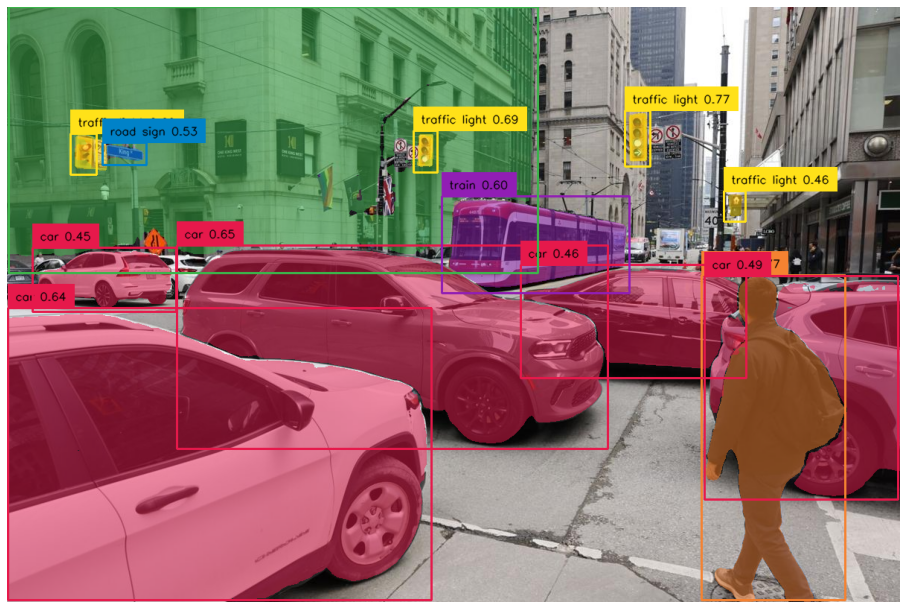

In [ ]:


SOURCE_IMAGE_PATH = "/app/images/road_traffic_1.jpg"
CLASSES = ['car', 'building', 'traffic light', 'road sign', 'person', 'train']
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25
sam
image = cv2.imread(SOURCE_IMAGE_PATH)

print(f"image shape : {image.shape}")
# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)


#XXXXXXXXXXXXXXXXXXXXXX BBOXES VISUALIZATION XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# # annotate image with detections
# box_annotator = sv.BoxAnnotator()
# labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
# annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# %matplotlib inline
# sv.plot_image(annotated_frame, (16, 16))
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [ ]:
a = np.ones([3,3])
a = np.tile(a, 3)[..., None].transpose(2,1,0)
print(f"{a.shape}")
a


(1, 9, 3)


array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

detections.masks

<h1> RESNET EMBEDDINGS </h1>

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
# from datasets import load_dataset

# dataset = load_dataset("huggingface/cats-image")
# image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


limousine, limo


<h1> Resnet prediction on Masks </h1>

image shape : (800, 1200, 3)
detections type : <class 'numpy.ndarray'>
detections shape : (13, 800, 1200)
xmin : 361, ymin : 933, xmax : 797, ymax 1126
masked image crop shape ; (436, 193, 3)


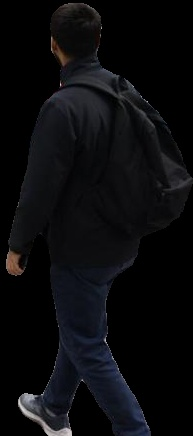


PREDICTED CLASS : abaya

xmin : 140, ymin : 830, xmax : 215, ymax 864
masked image crop shape ; (75, 34, 3)


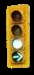


PREDICTED CLASS : hourglass

xmin : 321, ymin : 228, xmax : 594, ymax 807
masked image crop shape ; (273, 579, 3)


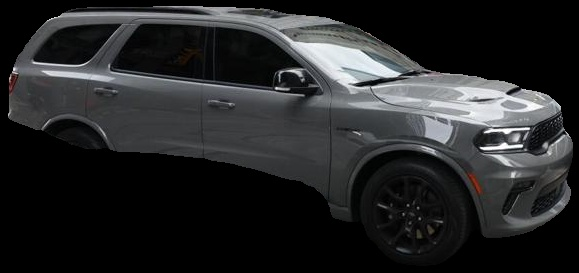


PREDICTED CLASS : minivan

xmin : 405, ymin : 1, xmax : 797, ymax 570
masked image crop shape ; (392, 569, 3)


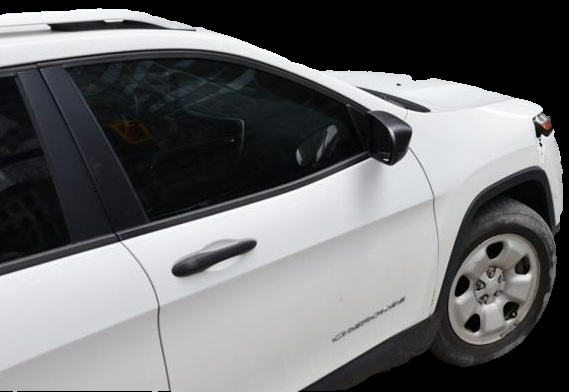


PREDICTED CLASS : sports car, sport car

xmin : 171, ymin : 85, xmax : 226, ymax 120
masked image crop shape ; (55, 35, 3)


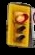


PREDICTED CLASS : rotisserie

xmin : 167, ymin : 546, xmax : 223, ymax 578
masked image crop shape ; (56, 32, 3)


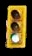


PREDICTED CLASS : ping-pong ball

xmin : 347, ymin : 690, xmax : 499, ymax 993
masked image crop shape ; (152, 303, 3)


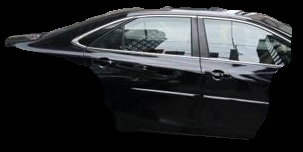


PREDICTED CLASS : beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon

xmin : 183, ymin : 128, xmax : 213, ymax 187
masked image crop shape ; (30, 59, 3)



PREDICTED CLASS : chain saw, chainsaw

xmin : 324, ymin : 34, xmax : 410, ymax 227
masked image crop shape ; (86, 193, 3)


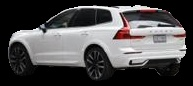


PREDICTED CLASS : minivan

xmin : 255, ymin : 584, xmax : 385, ymax 836
masked image crop shape ; (130, 252, 3)


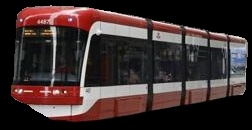


PREDICTED CLASS : streetcar, tram, tramcar, trolley, trolley car

xmin : 248, ymin : 963, xmax : 289, ymax 992
masked image crop shape ; (41, 29, 3)



PREDICTED CLASS : bearskin, busby, shako

xmin : 1, ymin : 2, xmax : 358, ymax 713
masked image crop shape ; (357, 711, 3)


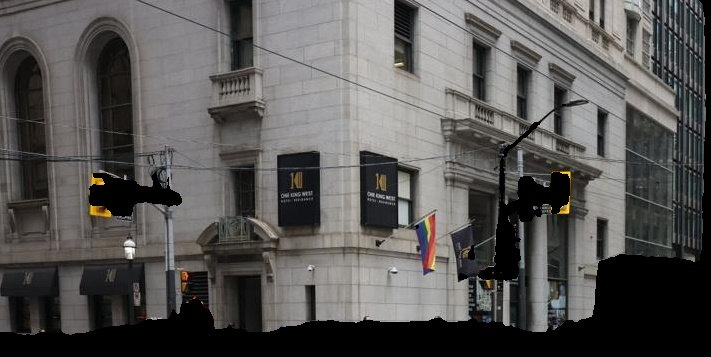


PREDICTED CLASS : cinema, movie theater, movie theatre, movie house, picture palace

xmin : 362, ymin : 937, xmax : 662, ymax 1197
masked image crop shape ; (300, 260, 3)


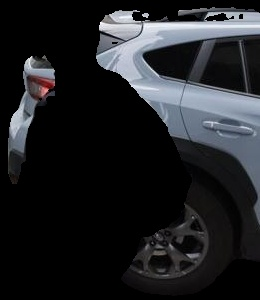


PREDICTED CLASS : hoopskirt, crinoline



In [ ]:
from IPython.display import Image as im 
from IPython.display import display as dis 

print(f"image shape : {image.shape}")
print(f"detections type : {type(detections.mask)}")
print(f"detections shape : {detections.mask.shape}")
masks = detections.mask
masks = masks.astype(int)


with torch.no_grad():
    for i in range(len(masks)):

        masked_image = image * np.concatenate([masks[i][..., None],
                    masks[i][..., None],
                    masks[i][..., None]], axis = 2)
    
        ymin, xmin, ymax, xmax = detections.xyxy[i].astype(int)
        print(f"xmin : {xmin}, ymin : {ymin}, xmax : {xmax}, ymax {ymax}")
        print(f"masked image crop shape ; {masked_image[xmin:xmax, ymin:ymax, :].shape}")
        masked_image = masked_image[xmin:xmax, ymin:ymax, :]
        cv2.imwrite("temp.jpg", masked_image)
        dis(im("temp.jpg"))

        #   RESNET PREDICTION 
        inputs = processor(masked_image, return_tensors="pt")
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        print(f"\nPREDICTED CLASS : {model.config.id2label[predicted_label]}\n")


In [ ]:
dir(model.resnet)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_convert_head_mask_to_5d',
 '_create_repo',
 '_expand_inputs_for_generation',
 '_extract_past_from_model_output',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_from_config',
 '_get_backward_hooks',
 '_get_decoder_start_token_id',
 '_get_files_timestamps',
 '_get_logits_processor',
 '_get_logits_warper',
 '_get_name',
 '_get_resized_embeddings',
 '_get_resized_lm_head',
 '_get_stopping_criteria',
 '_hook_rss_memory_p

In [ ]:
model.resnet

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

In [ ]:
print(inspect.getsource(model.forward))

    @add_start_docstrings_to_model_forward(RESNET_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        checkpoint=_IMAGE_CLASS_CHECKPOINT,
        output_type=ImageClassifierOutputWithNoAttention,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_IMAGE_CLASS_EXPECTED_OUTPUT,
    )
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> ImageClassifierOutputWithNoAttention:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict



In [ ]:
model.resnet(inputs)

AttributeError: 

In [ ]:
model(masked_image)

ValueError: Make sure that the channel dimension of the pixel values match with the one set in the configuration.

In [ ]:
import inspect
import pprint

print(inspect.getsource(model.get_output_embeddings))

    def get_output_embeddings(self) -> nn.Module:
        """
        Returns the model's output embeddings.

        Returns:
            `nn.Module`: A torch module mapping hidden states to vocabulary.
        """
        return None  # Overwrite for models with output embeddings



xmin : 321, ymin : 228, xmax : 594, ymax 807
masked image crop shape ; (273, 579, 3)


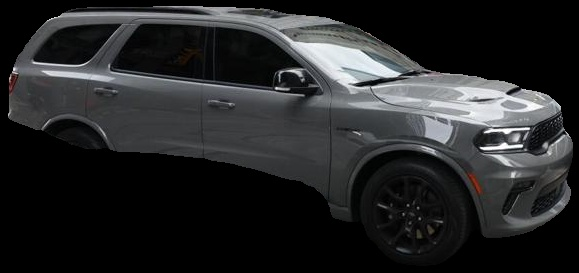


PREDICTED CLASS : minivan



In [ ]:
with torch.no_grad():
    i = 2
    masked_image = image * np.concatenate([masks[i][..., None],
                    masks[i][..., None],
                    masks[i][..., None]], axis = 2)

    ymin, xmin, ymax, xmax = detections.xyxy[i].astype(int)
    print(f"xmin : {xmin}, ymin : {ymin}, xmax : {xmax}, ymax {ymax}")
    print(f"masked image crop shape ; {masked_image[xmin:xmax, ymin:ymax, :].shape}")
    masked_image = masked_image[xmin:xmax, ymin:ymax, :]
    cv2.imwrite("temp.jpg", masked_image)
    dis(im("temp.jpg"))

    #   RESNET PREDICTION 
    inputs = processor(masked_image, return_tensors="pt")
    logits = model(**inputs).logits
    predicted_label = logits.argmax(-1).item()
    print(f"\nPREDICTED CLASS : {model.config.id2label[predicted_label]}\n")

<h1> viz masks alone </h1>

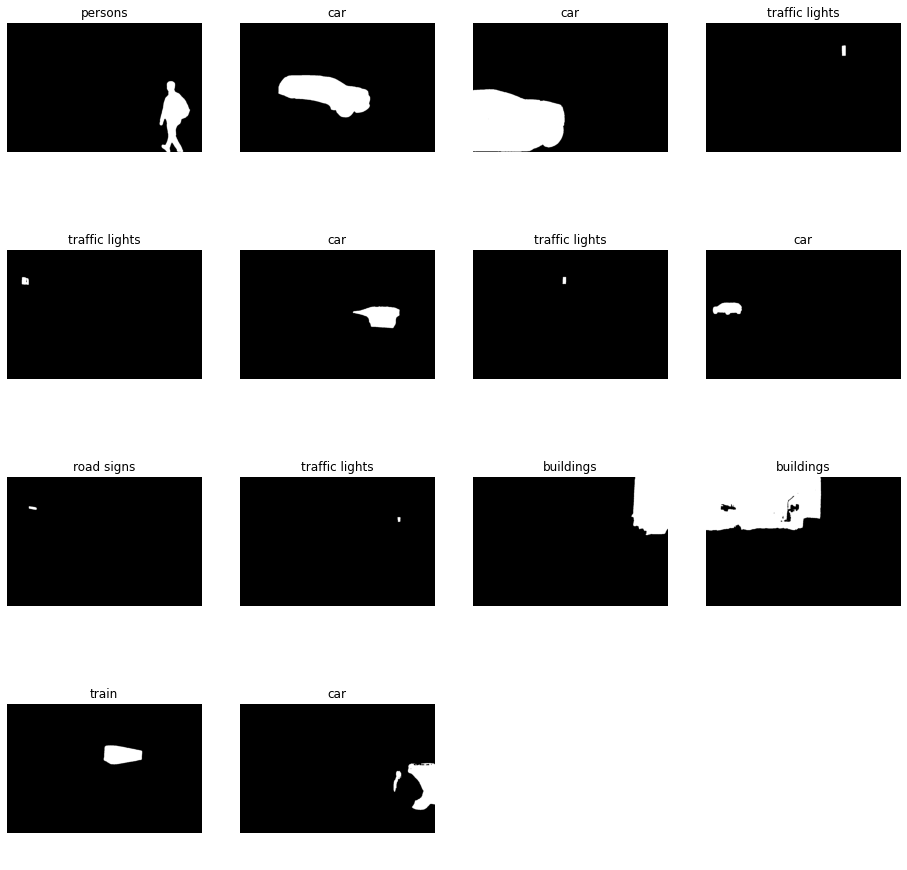

In [ ]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16)
)